In [2]:
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db
import kwant
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla
from ccode.boundstate import find_boundstates, extract_boundstates
import time
import itertools as it

%matplotlib inline
plt.rcParams.update({"font.size": 12})

## Parallel computing configuration

In [3]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 4  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [4]:
cluster = Cluster(options)

In [5]:
cluster

In [6]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/34aaf767223f42ff827d00a24ea21086/status


In [7]:
client = cluster.get_client()

In [270]:
cluster.close()

# Analysis of bound state algorithm

#### Helper functions

In [8]:
def sort_eigen(ev):
    """
    Sort eigenvectors and eigenvalues using numpy methods.
    """
    evals, evecs = ev
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs.T


def extract_data_bound_states(data, mus):
    energies = [[] for j in range(10)]
    states = [[] for j in range(10)]
    non_zero_mus = [[] for j in range(10)]
    i = 0
    for dat in data:
        ens = dat[0]
        vecs = dat[1]
        if 0 not in ens.shape:
            ens = np.sort(ens[np.where(ens>0)])
            j = 0
            for e in ens:
                energies[j].append(e)
                non_zero_mus[j].append(mus[i])
                states[j].append(vecs[j])
                j += 1
        i += 1
    return energies, non_zero_mus, states

In [81]:
def add_phase(**params):
    params_copy = params.copy()
    Delta = params_copy['Delta']
    phi = params_copy.pop('phi')
    params_copy.update(Delta_im = np.sin(phi)*Delta)
    params_copy.update(Delta_re = np.cos(phi)*Delta)
    return params_copy

def bound_state_solver(key):

    def bound_state_iteration(system, mu, params):

        params[key] = mu
        en, vec = find_boundstates(syst=system,
                                   min_energy=-0.01,
                                   max_energy=0.01,
                                   sparse=True,
                                   params=add_phase(**params),
                                   rtol=1e-3
                                  )
        return en, vec

    return bound_state_iteration


solver_cavity_mu = bound_state_solver(key='mu_cavity')

def wrapper_cavity_mu(args):
    return solver_cavity_mu(*args)

In [82]:
# Hamiltonian of the system
lead_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""

lead_phase_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta_re * kron(sigma_0, sigma_x)
    + Delta_im * kron(sigma_0, sigma_y)
    + B_x * kron(sigma_x, sigma_0)
"""
a = 1
lead1_template = kwant.continuum.discretize(lead_hamiltonian, grid=a)
lead2_template = kwant.continuum.discretize(lead_phase_hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

In [28]:
def interval_shape(L, W):
    def shape(site):
        return 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
    return shape


def make_junction(L, W):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=interval_shape(L, W),
        start=[0,0]
    )
    return junction

In [29]:
def circle_junction_shape(r, l, w):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2 or np.abs(x) < l + r and np.abs(y) < w
    return shape


def make_circular_junction(r, l, w):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=circle_junction_shape(r, l, w),
        start=[0,0]
    )
    return junction


def shape_wires_circle(r, mu_circle, mu_wires):
    def shape(x, y):
        if x**2 + y**2 < r**2:
            return mu_circle
        else:
            return mu_wires
    return shape


def f_params_circular_junction(r, **parameters):

    params = parameters.copy()
    mu_circle = params.pop('mu_cavity')
    mu_wires = params.pop('mu_wires')
    Delta = params.pop('Delta')

    params.update(mu=shape_wires_circle(r=r,
                                        mu_circle=mu_circle,
                                        mu_wires=mu_wires))
    params.update(Delta=shape_wires_circle(r=r,
                                           mu_circle=0,
                                           mu_wires=Delta))

    return params

# Single nanowire

### Infinite system

In [383]:
L = 1
W = 3
rectangle = make_junction(L, W)

In [384]:
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
lead.fill(template, shape=lambda site: 0 <= site.pos[1] < W, start=[0, 0]);
rectangle.attach_lead(lead)
rectangle = rectangle.finalized()

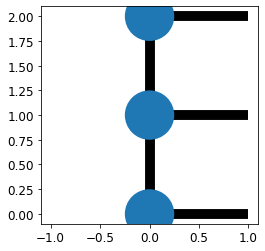

In [385]:
kwant.plot(lead);

In [16]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [17]:
%%time
start = time.time()
en, vec = find_boundstates(syst=rectangle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=params,
                           rtol=1e-1
                          )
end = time.time()
print(end-start)

0.0004477500915527344
CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 990 µs


In [18]:
%%time
inf_ens = []
inf_vecs = []
Bs = np.linspace(0, 1, 100)
for b in Bs:
    params['B_x'] = b
    en, vec = find_boundstates(syst=rectangle,
                               min_energy=-0.01,
                               max_energy=0.01,
                               sparse=True,
                               params=params,
                               rtol=1e-2
                              )
    inf_ens.append(en)
    inf_vecs.append(vec)

CPU times: user 33.3 s, sys: 131 ms, total: 33.4 s
Wall time: 33.4 s


In [19]:
w = np.where(np.abs(inf_ens)>0)[0][0]

/tmp/ipykernel_849/149243906.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w = np.where(np.abs(inf_ens)>0)[0][0]
/tmp/ipykernel_849/149243906.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  w = np.where(np.abs(inf_ens)>0)[0][0]


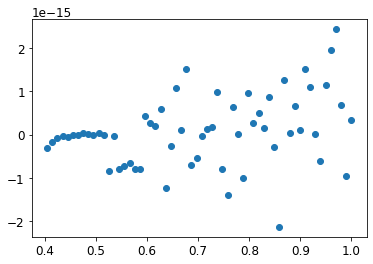

In [20]:
plt.scatter(Bs[w:], inf_ens[w:])

In [21]:
density = kwant.operator.Density(rectangle, np.eye(4))

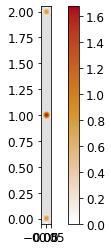

/tmp/ipykernel_849/3048305456.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(rectangle, density(inf_vecs[w][:, 0]));


In [22]:
kwant.plotter.density(rectangle, density(inf_vecs[w][:, 0]));

In [23]:
%%time
inf_vecs_0 = []
for b in Bs:
    params['B_x'] = b
    vec = extract_boundstates(syst=rectangle,
                             energy=0,
                             sparse=True,
                             params=params
                             )
    inf_vecs_0.append(vec)

CPU times: user 2.17 s, sys: 85.9 ms, total: 2.25 s
Wall time: 2.24 s


#### Notes on bound state algorithm:
* `fing_boundstates` takes longer when there's no bound state in the system.
* `extract_boundstate` is the fastest, but requires providing the energy.

### Finite system

In [24]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.011
}

In [25]:
finite_wire = make_junction(100, 3).finalized()

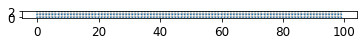

In [26]:
kwant.plot(finite_wire);

In [242]:
%%time
fin_ens = []
fin_vecs = []
for b in Bs:
    params['B_x'] = b
    ham = finite_wire.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=10, sigma=0))
    fin_ens.append(val)
    fin_vecs.append(vec)

CPU times: user 2.68 s, sys: 15 ms, total: 2.7 s
Wall time: 2.69 s


In [243]:
fin_ens = np.array(fin_ens)

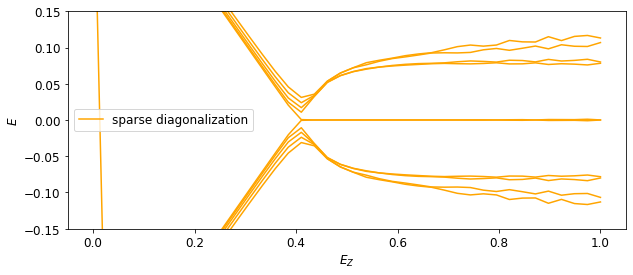

In [244]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in fin_ens.T:
    ax.plot(Bs, level, label='sparse diagonalization', c='orange')
#ax.scatter(Bs[w:], inf_ens[w:], label='bound state algorithm')
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left')

In [30]:
density = kwant.operator.Density(finite_wire, np.eye(4))

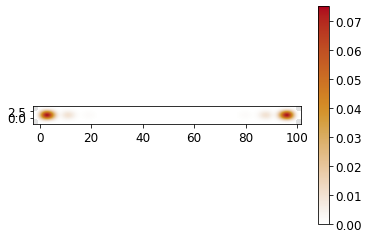

/tmp/ipykernel_849/3342805614.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(finite_wire, density(fin_vecs[50][5]));


In [31]:
kwant.plotter.density(finite_wire, density(fin_vecs[50][5]));

# Circular cavity with two leads

In [30]:
cavity_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu_cavity) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + B_x * kron(sigma_x, sigma_0)
"""

cavity_template = kwant.continuum.discretize(cavity_hamiltonian)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [31]:
def circle_shape(r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2
    return shape


def make_circular_cavity(r):
    junction = kwant.Builder()
    junction.fill(
        cavity_template,
        shape=circle_shape(r),
        start=[0,0]
    )
    return junction

In [57]:
circle = make_circular_cavity(r=14)
lead_1 = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
lead_2 = kwant.Builder(symmetry=kwant.TranslationalSymmetry([1, 0]))
W = 3
x0 = -9
y0 = 0
lead_1.fill(lead1_template,
          shape=lambda site: -W/2 + y0 <= site.pos[1] < W/2 + y0,
          start=[x0, y0]);
circle.attach_lead(lead_1)
lead_2.fill(lead2_template,
          shape=lambda site: -W/2 + y0 <= site.pos[1] < W/2 + y0,
          start=[x0, y0]);
circle.attach_lead(lead_2)
circle = circle.finalized()

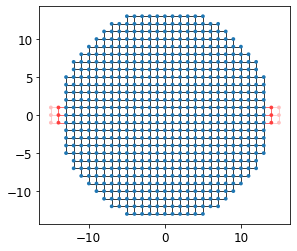

In [58]:
kwant.plot(circle);

### Cavity eigenstates

In [59]:
params = {
    't': 1,
    'mu': 0,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [60]:
%%time
cavity_ens = []
cavity_vecs = []
mus = np.linspace(-1, 1, 100)
for b in mus:
    params['mu_cavity'] = b
    ham = circle.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=10, sigma=0))
    cavity_ens.append(val)
    cavity_vecs.append(vec)

CPU times: user 10.4 s, sys: 210 ms, total: 10.6 s
Wall time: 10.6 s


In [61]:
cavity_ens = np.array(cavity_ens)

Text(0.5, 0, '$\\mu_c$')

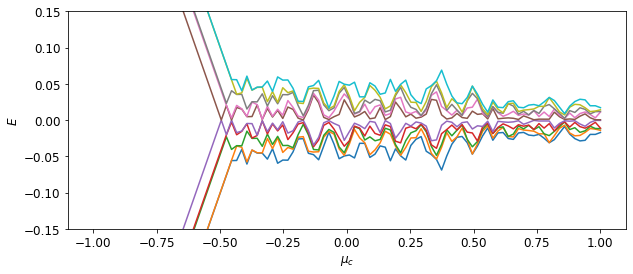

In [62]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in cavity_ens.T:
    ax.plot(mus, level)
#ax.scatter(Bs[w:], inf_ens[w:], label='bound state algorithm')
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$\mu_c$')

### Majorana states

In [63]:
solver_B = bound_state_solver(key='B_x')

In [64]:
def wrapper_B(args):
    return solver_B(*args)

In [65]:
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': -2,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [67]:
en, vec = find_boundstates(syst=circle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=add_phase(**params),
                           rtol=1e-3
                          )

In [68]:
en

array([-9.7795036e-17, -9.7795036e-17])

In [69]:
Bs = np.linspace(0, 1, 40)
args = list(it.product([circle], Bs, [params]))

In [70]:
%%time
args_db = db.from_sequence(args, npartitions=20)
result = args_db.map(wrapper_B).compute()

CPU times: user 4.17 s, sys: 46.1 ms, total: 4.22 s
Wall time: 2min 9s


In [71]:
energies, non_zero_Bs, states = extract_data_bound_states(data=result, mus=Bs)

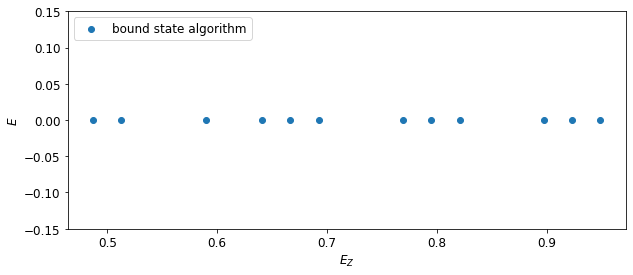

In [73]:
fig, ax = plt.subplots(figsize=(10, 4))
#for level in fin_ens.T:
 #   ax.plot(Bs, level, label='sparse diagonalization', c='orange')
ax.scatter(non_zero_Bs[0], energies[0], label='bound state algorithm')
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

### Superconducting phase dependence

In [255]:
solver_phi = bound_state_solver(key='phi')

In [256]:
def wrapper_phi(args):
    return solver_phi(*args)

In [257]:
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [258]:
phis = np.linspace(0, 2*np.pi, 50)
args = list(it.product([circle], phis, [params]))

In [259]:
params_replaced = []
for phi in phis:
    params.update(phi=phi)
    params_replaced.append(add_phase(**params))

In [260]:
%%time
args_db = db.from_sequence(args, npartitions=20)
result = args_db.map(wrapper_phi).compute()

CPU times: user 5.01 s, sys: 72.1 ms, total: 5.08 s
Wall time: 1min 55s


In [261]:
energies_phi, non_zero_phi, states = extract_data_bound_states(data=result, mus=phis)

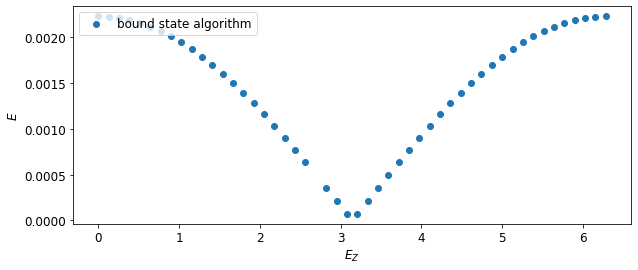

In [262]:
fig, ax = plt.subplots(figsize=(10, 4))
#for level in fin_ens.T:
 #   ax.plot(Bs, level, label='sparse diagonalization', c='orange')
ax.scatter(non_zero_phi[0], energies_phi[0], label='bound state algorithm')

ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')


#### Finite system

In [237]:
# Hamiltonian of the system
hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu(x,y)) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta_re(x,y) * kron(sigma_0, sigma_x)
    + Delta_im(x,y) * kron(sigma_0, sigma_y)
    + B_x * kron(sigma_x, sigma_0)
"""
a = 1
template = kwant.continuum.discretize(hamiltonian)


def circle_junction_shape(r, l, w):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2 or np.abs(x) < l + r and np.abs(y) < w/2
    return shape


def make_circular_junction(r, l, w):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=circle_junction_shape(r, l, w),
        start=[0, 0]
    )
    return junction


def shape_wires_circle(r, mu_circle, mu_wires):
    def shape(x, y):
        if x**2 + y**2 < r**2:
            return mu_circle
        else:
            return mu_wires
    return shape


def superconducting_phase(r, Delta, phi):

    def real_phase(x, y):
        if x < -r:
            return Delta*np.cos(phi)
        elif x > r:
            return Delta
        else:
            return 0

    def imaginary_phase(x, y):
        if x < -r:
            return Delta*np.sin(phi)
        else:
            return 0

    return real_phase, imaginary_phase


def f_params_circular_junction(r, **parameters):
    #print(parameters)
    params = parameters.copy()
    mu_circle = params.pop('mu_cavity')
    mu_wires = params.pop('mu_wires')
    Delta = params['Delta']
    phi = params.pop('phi')
    Delta_re, Delta_im = superconducting_phase(r, Delta, phi)
    params.update(Delta_re=Delta_re)
    params.update(Delta_im=Delta_im)

    params.update(mu=shape_wires_circle(r=r,
                                        mu_circle=mu_circle,
                                        mu_wires=mu_wires))


    return params

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [238]:
f_params_circular_junction(14, **params)

{'t': 1,
 'alpha': 0.3,
 'Delta': 0.3,
 'B_x': 0.5,
 'Delta_re': <function __main__.superconducting_phase.<locals>.real_phase(x, y)>,
 'Delta_im': <function __main__.superconducting_phase.<locals>.imaginary_phase(x, y)>,
 'mu': <function __main__.shape_wires_circle.<locals>.shape(x, y)>}

In [239]:
j = make_circular_junction(r=14, l=200, w=3).finalized()

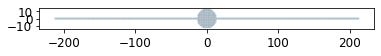

In [240]:
kwant.plot(j);

In [241]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [264]:
phis = np.linspace(0, 2*np.pi, 100)

In [252]:
%%time
cavity_ens = []
cavity_vecs = []
for b in phis:
    params['phi'] = b
    ham = j.hamiltonian_submatrix(sparse=True,
                                  params=f_params_circular_junction(r=14, **params))
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=8, sigma=0))
    cavity_ens.append(val)
    cavity_vecs.append(vec)

CPU times: user 26.2 s, sys: 361 ms, total: 26.5 s
Wall time: 26.5 s


In [265]:
cavity_ens = np.array(cavity_ens)

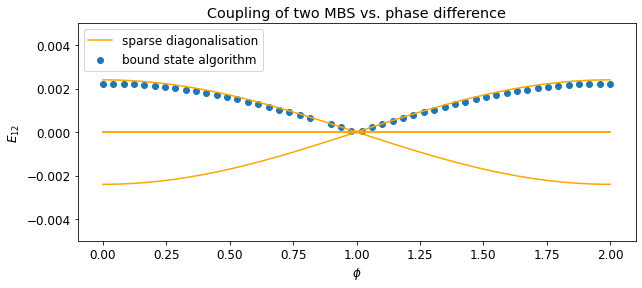

In [269]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in cavity_ens.T:
    ax.plot(phis/np.pi, level, c='orange', label='sparse diagonalisation')
ax.scatter(np.array(non_zero_phi[0])/np.pi, energies_phi[0], label='bound state algorithm')
ax.set_ylim(-0.005, 0.005)
ax.set_title('Coupling of two MBS vs. phase difference')
ax.set_ylabel('$E_{12}$')
ax.set_xlabel(r'$\phi$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

In [212]:
density = kwant.operator.Density(j, np.eye(4))

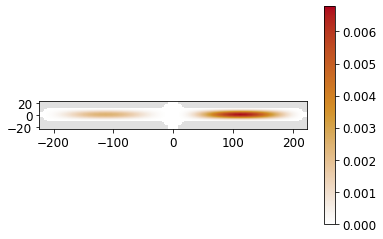

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


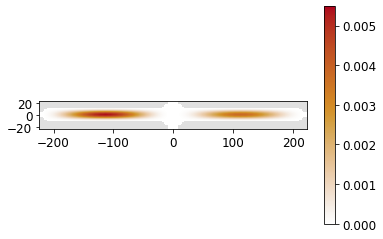

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


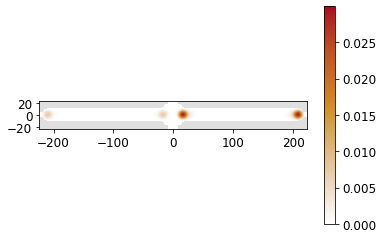

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


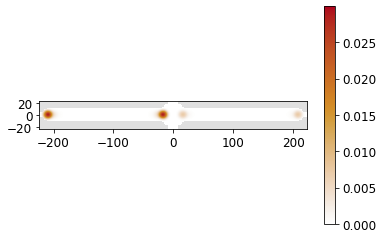

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


In [213]:
for i in range(4):
    kwant.plotter.density(j, density(cavity_vecs[0][i]));

### Couple Majorana states

#### Infinite system

In [293]:
solver_mu = bound_state_solver(key='mu_cavity')

In [294]:
def wrapper_mu(args):
    return solver_mu(*args)

In [295]:
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': -2,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [296]:
mus = np.linspace(-0.65, -0.25, 80)
args = list(it.product([circle], mus, [params]))

In [297]:
%%time
args_db = db.from_sequence(args, npartitions=20)
result = args_db.map(wrapper_mu).compute()

CPU times: user 7.25 s, sys: 251 ms, total: 7.5 s
Wall time: 9min 22s


In [307]:
energies, non_zero_mus, states = extract_data_bound_states(data=result, mus=mus)

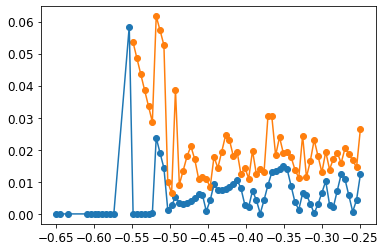

In [320]:
for i in range(2):
    plt.scatter(non_zero_mus[i], energies[i], label=str(i)+'-th bound state energy')
    plt.plot(non_zero_mus[i], energies[i])